In [1]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Load pretrained
ResNet18 = models.resnet18(pretrained=True)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ResNet18 = ResNet18.to(device)

# Print model summary
summary(ResNet18, (3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [2]:

# Test transform (no augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------------------------
# CIFAR-10 Dataset and Dataloaders
# ------------------------------------------
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


100%|██████████| 170M/170M [00:50<00:00, 3.37MB/s]


In [3]:
feature_extractor = nn.Sequential(*list(ResNet18.children())[:-1])

feature_extractor.eval()
feature_extractor.to(device)

train_features = []
train_labels = []

with torch.no_grad():
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        features = feature_extractor(images)              # (B, 512, 1, 1)
        features = features.view(features.size(0), -1)    # (B, 512)
        train_features.append(features.cpu())
        train_labels.append(labels)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)

test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        features = feature_extractor(images)              # (B, 512, 1, 1)
        features = features.view(features.size(0), -1)    # (B, 512)
        test_features.append(features.cpu())
        test_labels.append(labels)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 157/157 [00:18<00:00,  8.60it/s]


In [6]:
epochs = 75
train_losses = []
train_acc = []
test_losses = []
test_acc = []

# classifier = nn.Linear(256, 10).to(device)
# Linear classifier with Dropout
classifier = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(256, 10)
).to(device)


optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\nEpoch [{epoch+1}/{epochs}]")
    progress_bar = tqdm(trainloader, desc="Training", leave=False)

    for features, labels in progress_bar:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            'Batch Loss': f"{loss.item():.4f}",
            'Acc': f"{100 * correct / total:.2f}%"
        })

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    train_acc.append(100 * correct / total)
    print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

    scheduler.step()
    print(f"Learning Rate after epoch {epoch+1}: {scheduler.get_last_lr()[0]:.6f}")

    classifier.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for features, labels in testloader:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            test_total += labels.size(0)

    avg_test_loss = test_loss / len(testloader)
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_acc.append(test_accuracy)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Epoch [1/75]


Epoch [1/75] - Avg Loss: 0.6585, Accuracy: 77.16%
Learning Rate after epoch 1: 0.000900
Test Loss: 0.4635, Test Accuracy: 84.31%

Epoch [2/75]


Epoch [2/75] - Avg Loss: 0.5376, Accuracy: 81.25%
Learning Rate after epoch 2: 0.000810
Test Loss: 0.4370, Test Accuracy: 84.94%

Epoch [3/75]


Epoch [3/75] - Avg Loss: 0.5106, Accuracy: 82.05%
Learning Rate after epoch 3: 0.000729
Test Loss: 0.4232, Test Accuracy: 85.73%

Epoch [4/75]


Epoch [4/75] - Avg Loss: 0.4918, Accuracy: 82.69%
Learning Rate after epoch 4: 0.000656
Test Loss: 0.4068, Test Accuracy: 85.93%

Epoch [5/75]


Epoch [5/75] - Avg Loss: 0.4739, Accuracy: 83.35%
Learning Rate after epoch 5: 0.000590
Test Loss: 0.4010, Test Accuracy: 86.12%

Epoch [6/75]


Epoch [6/75] - Avg Loss: 0.4624, Accuracy: 83.62%
Learning Rate after epoch 6: 0.000531
Test Loss: 0.4060, Test Accuracy: 85.88%

Epoch [7/75]


Epoch [7/75] - Avg Loss: 0.4432, Accuracy: 84.55%
Learning Rate after epoch 7: 0.000478
Test Loss: 0.3923, Test Accuracy: 86.51%

Epoch [8/75]


Epoch [8/75] - Avg Loss: 0.4373, Accuracy: 84.63%
Learning Rate after epoch 8: 0.000430
Test Loss: 0.3864, Test Accuracy: 86.57%

Epoch [9/75]


Epoch [9/75] - Avg Loss: 0.4250, Accuracy: 84.98%
Learning Rate after epoch 9: 0.000387
Test Loss: 0.3746, Test Accuracy: 87.18%

Epoch [10/75]


Epoch [10/75] - Avg Loss: 0.4179, Accuracy: 85.18%
Learning Rate after epoch 10: 0.000349
Test Loss: 0.3784, Test Accuracy: 87.05%

Epoch [11/75]


Epoch [11/75] - Avg Loss: 0.4136, Accuracy: 85.34%
Learning Rate after epoch 11: 0.000314
Test Loss: 0.3707, Test Accuracy: 87.35%

Epoch [12/75]


Epoch [12/75] - Avg Loss: 0.4028, Accuracy: 85.92%
Learning Rate after epoch 12: 0.000282
Test Loss: 0.3709, Test Accuracy: 87.35%

Epoch [13/75]


Epoch [13/75] - Avg Loss: 0.3973, Accuracy: 86.00%
Learning Rate after epoch 13: 0.000254
Test Loss: 0.3715, Test Accuracy: 87.33%

Epoch [14/75]


Epoch [14/75] - Avg Loss: 0.3885, Accuracy: 86.40%
Learning Rate after epoch 14: 0.000229
Test Loss: 0.3616, Test Accuracy: 88.01%

Epoch [15/75]


Epoch [15/75] - Avg Loss: 0.3869, Accuracy: 86.47%
Learning Rate after epoch 15: 0.000206
Test Loss: 0.3595, Test Accuracy: 87.78%

Epoch [16/75]


Epoch [16/75] - Avg Loss: 0.3848, Accuracy: 86.32%
Learning Rate after epoch 16: 0.000185
Test Loss: 0.3605, Test Accuracy: 87.81%

Epoch [17/75]


Epoch [17/75] - Avg Loss: 0.3814, Accuracy: 86.51%
Learning Rate after epoch 17: 0.000167
Test Loss: 0.3586, Test Accuracy: 87.91%

Epoch [18/75]


Epoch [18/75] - Avg Loss: 0.3763, Accuracy: 86.78%
Learning Rate after epoch 18: 0.000150
Test Loss: 0.3588, Test Accuracy: 87.89%

Epoch [19/75]


Epoch [19/75] - Avg Loss: 0.3747, Accuracy: 86.85%
Learning Rate after epoch 19: 0.000135
Test Loss: 0.3604, Test Accuracy: 87.96%

Epoch [20/75]


Epoch [20/75] - Avg Loss: 0.3666, Accuracy: 86.93%
Learning Rate after epoch 20: 0.000122
Test Loss: 0.3575, Test Accuracy: 87.96%

Epoch [21/75]


Epoch [21/75] - Avg Loss: 0.3700, Accuracy: 87.02%
Learning Rate after epoch 21: 0.000109
Test Loss: 0.3576, Test Accuracy: 87.89%

Epoch [22/75]


Epoch [22/75] - Avg Loss: 0.3653, Accuracy: 86.98%
Learning Rate after epoch 22: 0.000098
Test Loss: 0.3523, Test Accuracy: 88.31%

Epoch [23/75]


Epoch [23/75] - Avg Loss: 0.3659, Accuracy: 86.98%
Learning Rate after epoch 23: 0.000089
Test Loss: 0.3533, Test Accuracy: 87.99%

Epoch [24/75]


Epoch [24/75] - Avg Loss: 0.3605, Accuracy: 87.23%
Learning Rate after epoch 24: 0.000080
Test Loss: 0.3511, Test Accuracy: 88.06%

Epoch [25/75]


Epoch [25/75] - Avg Loss: 0.3587, Accuracy: 87.28%
Learning Rate after epoch 25: 0.000072
Test Loss: 0.3529, Test Accuracy: 88.06%

Epoch [26/75]


Epoch [26/75] - Avg Loss: 0.3581, Accuracy: 87.23%
Learning Rate after epoch 26: 0.000065
Test Loss: 0.3510, Test Accuracy: 88.08%

Epoch [27/75]


Epoch [27/75] - Avg Loss: 0.3554, Accuracy: 87.37%
Learning Rate after epoch 27: 0.000058
Test Loss: 0.3515, Test Accuracy: 88.09%

Epoch [28/75]


Epoch [28/75] - Avg Loss: 0.3557, Accuracy: 87.55%
Learning Rate after epoch 28: 0.000052
Test Loss: 0.3506, Test Accuracy: 88.16%

Epoch [29/75]


Epoch [29/75] - Avg Loss: 0.3558, Accuracy: 87.35%
Learning Rate after epoch 29: 0.000047
Test Loss: 0.3503, Test Accuracy: 88.28%

Epoch [30/75]


Epoch [30/75] - Avg Loss: 0.3533, Accuracy: 87.76%
Learning Rate after epoch 30: 0.000042
Test Loss: 0.3504, Test Accuracy: 88.05%

Epoch [31/75]


Epoch [31/75] - Avg Loss: 0.3549, Accuracy: 87.44%
Learning Rate after epoch 31: 0.000038
Test Loss: 0.3480, Test Accuracy: 88.27%

Epoch [32/75]


Epoch [32/75] - Avg Loss: 0.3502, Accuracy: 87.68%
Learning Rate after epoch 32: 0.000034
Test Loss: 0.3492, Test Accuracy: 88.33%

Epoch [33/75]


Epoch [33/75] - Avg Loss: 0.3527, Accuracy: 87.60%
Learning Rate after epoch 33: 0.000031
Test Loss: 0.3501, Test Accuracy: 88.04%

Epoch [34/75]


Epoch [34/75] - Avg Loss: 0.3526, Accuracy: 87.51%
Learning Rate after epoch 34: 0.000028
Test Loss: 0.3496, Test Accuracy: 88.33%

Epoch [35/75]


Epoch [35/75] - Avg Loss: 0.3532, Accuracy: 87.44%
Learning Rate after epoch 35: 0.000025
Test Loss: 0.3501, Test Accuracy: 88.31%

Epoch [36/75]


Epoch [36/75] - Avg Loss: 0.3501, Accuracy: 87.69%
Learning Rate after epoch 36: 0.000023
Test Loss: 0.3485, Test Accuracy: 88.32%

Epoch [37/75]


Epoch [37/75] - Avg Loss: 0.3478, Accuracy: 87.92%
Learning Rate after epoch 37: 0.000020
Test Loss: 0.3488, Test Accuracy: 88.23%

Epoch [38/75]


Epoch [38/75] - Avg Loss: 0.3461, Accuracy: 87.68%
Learning Rate after epoch 38: 0.000018
Test Loss: 0.3484, Test Accuracy: 88.33%

Epoch [39/75]


Epoch [39/75] - Avg Loss: 0.3490, Accuracy: 87.74%
Learning Rate after epoch 39: 0.000016
Test Loss: 0.3490, Test Accuracy: 88.31%

Epoch [40/75]


Epoch [40/75] - Avg Loss: 0.3474, Accuracy: 87.85%
Learning Rate after epoch 40: 0.000015
Test Loss: 0.3487, Test Accuracy: 88.30%

Epoch [41/75]


Epoch [41/75] - Avg Loss: 0.3476, Accuracy: 87.58%
Learning Rate after epoch 41: 0.000013
Test Loss: 0.3495, Test Accuracy: 88.31%

Epoch [42/75]


Epoch [42/75] - Avg Loss: 0.3451, Accuracy: 87.78%
Learning Rate after epoch 42: 0.000012
Test Loss: 0.3479, Test Accuracy: 88.30%

Epoch [43/75]


Epoch [43/75] - Avg Loss: 0.3502, Accuracy: 87.66%
Learning Rate after epoch 43: 0.000011
Test Loss: 0.3482, Test Accuracy: 88.40%

Epoch [44/75]


Epoch [44/75] - Avg Loss: 0.3480, Accuracy: 87.55%
Learning Rate after epoch 44: 0.000010
Test Loss: 0.3481, Test Accuracy: 88.40%

Epoch [45/75]


Epoch [45/75] - Avg Loss: 0.3475, Accuracy: 87.68%
Learning Rate after epoch 45: 0.000009
Test Loss: 0.3487, Test Accuracy: 88.31%

Epoch [46/75]


Epoch [46/75] - Avg Loss: 0.3451, Accuracy: 87.69%
Learning Rate after epoch 46: 0.000008
Test Loss: 0.3479, Test Accuracy: 88.32%

Epoch [47/75]


Epoch [47/75] - Avg Loss: 0.3443, Accuracy: 87.73%
Learning Rate after epoch 47: 0.000007
Test Loss: 0.3479, Test Accuracy: 88.39%

Epoch [48/75]


Epoch [48/75] - Avg Loss: 0.3475, Accuracy: 87.67%
Learning Rate after epoch 48: 0.000006
Test Loss: 0.3479, Test Accuracy: 88.40%

Epoch [49/75]


Epoch [49/75] - Avg Loss: 0.3436, Accuracy: 87.88%
Learning Rate after epoch 49: 0.000006
Test Loss: 0.3477, Test Accuracy: 88.40%

Epoch [50/75]


Epoch [50/75] - Avg Loss: 0.3455, Accuracy: 87.83%
Learning Rate after epoch 50: 0.000005
Test Loss: 0.3477, Test Accuracy: 88.42%

Epoch [51/75]


Epoch [51/75] - Avg Loss: 0.3442, Accuracy: 87.96%
Learning Rate after epoch 51: 0.000005
Test Loss: 0.3476, Test Accuracy: 88.44%

Epoch [52/75]


Epoch [52/75] - Avg Loss: 0.3471, Accuracy: 87.78%
Learning Rate after epoch 52: 0.000004
Test Loss: 0.3480, Test Accuracy: 88.36%

Epoch [53/75]


Epoch [53/75] - Avg Loss: 0.3442, Accuracy: 87.82%
Learning Rate after epoch 53: 0.000004
Test Loss: 0.3476, Test Accuracy: 88.42%

Epoch [54/75]


Epoch [54/75] - Avg Loss: 0.3447, Accuracy: 87.73%
Learning Rate after epoch 54: 0.000003
Test Loss: 0.3477, Test Accuracy: 88.38%

Epoch [55/75]


Epoch [55/75] - Avg Loss: 0.3432, Accuracy: 87.94%
Learning Rate after epoch 55: 0.000003
Test Loss: 0.3476, Test Accuracy: 88.40%

Epoch [56/75]


Epoch [56/75] - Avg Loss: 0.3453, Accuracy: 87.83%
Learning Rate after epoch 56: 0.000003
Test Loss: 0.3476, Test Accuracy: 88.40%

Epoch [57/75]


Epoch [57/75] - Avg Loss: 0.3451, Accuracy: 87.78%
Learning Rate after epoch 57: 0.000002
Test Loss: 0.3474, Test Accuracy: 88.45%

Epoch [58/75]


Epoch [58/75] - Avg Loss: 0.3447, Accuracy: 87.80%
Learning Rate after epoch 58: 0.000002
Test Loss: 0.3475, Test Accuracy: 88.36%

Epoch [59/75]


Epoch [59/75] - Avg Loss: 0.3438, Accuracy: 87.86%
Learning Rate after epoch 59: 0.000002
Test Loss: 0.3476, Test Accuracy: 88.38%

Epoch [60/75]


Epoch [60/75] - Avg Loss: 0.3437, Accuracy: 87.97%
Learning Rate after epoch 60: 0.000002
Test Loss: 0.3475, Test Accuracy: 88.36%

Epoch [61/75]


Epoch [61/75] - Avg Loss: 0.3437, Accuracy: 87.95%
Learning Rate after epoch 61: 0.000002
Test Loss: 0.3475, Test Accuracy: 88.39%

Epoch [62/75]


Epoch [62/75] - Avg Loss: 0.3464, Accuracy: 87.67%
Learning Rate after epoch 62: 0.000001
Test Loss: 0.3475, Test Accuracy: 88.40%

Epoch [63/75]


Epoch [63/75] - Avg Loss: 0.3436, Accuracy: 87.78%
Learning Rate after epoch 63: 0.000001
Test Loss: 0.3474, Test Accuracy: 88.37%

Epoch [64/75]


Epoch [64/75] - Avg Loss: 0.3443, Accuracy: 87.79%
Learning Rate after epoch 64: 0.000001
Test Loss: 0.3475, Test Accuracy: 88.40%

Epoch [65/75]


Epoch [65/75] - Avg Loss: 0.3463, Accuracy: 87.76%
Learning Rate after epoch 65: 0.000001
Test Loss: 0.3476, Test Accuracy: 88.36%

Epoch [66/75]


Epoch [66/75] - Avg Loss: 0.3411, Accuracy: 87.91%
Learning Rate after epoch 66: 0.000001
Test Loss: 0.3476, Test Accuracy: 88.39%

Epoch [67/75]


Epoch [67/75] - Avg Loss: 0.3489, Accuracy: 87.64%
Learning Rate after epoch 67: 0.000001
Test Loss: 0.3476, Test Accuracy: 88.36%

Epoch [68/75]


Epoch [68/75] - Avg Loss: 0.3437, Accuracy: 87.78%
Learning Rate after epoch 68: 0.000001
Test Loss: 0.3476, Test Accuracy: 88.36%

Epoch [69/75]


Epoch [69/75] - Avg Loss: 0.3439, Accuracy: 87.84%
Learning Rate after epoch 69: 0.000001
Test Loss: 0.3476, Test Accuracy: 88.37%

Epoch [70/75]


Epoch [70/75] - Avg Loss: 0.3474, Accuracy: 87.75%
Learning Rate after epoch 70: 0.000001
Test Loss: 0.3476, Test Accuracy: 88.39%

Epoch [71/75]


Epoch [71/75] - Avg Loss: 0.3468, Accuracy: 87.71%
Learning Rate after epoch 71: 0.000001
Test Loss: 0.3476, Test Accuracy: 88.37%

Epoch [72/75]


Epoch [72/75] - Avg Loss: 0.3455, Accuracy: 87.62%
Learning Rate after epoch 72: 0.000001
Test Loss: 0.3475, Test Accuracy: 88.35%

Epoch [73/75]


Epoch [73/75] - Avg Loss: 0.3444, Accuracy: 87.85%
Learning Rate after epoch 73: 0.000000
Test Loss: 0.3475, Test Accuracy: 88.36%

Epoch [74/75]


Epoch [74/75] - Avg Loss: 0.3425, Accuracy: 87.89%
Learning Rate after epoch 74: 0.000000
Test Loss: 0.3475, Test Accuracy: 88.35%

Epoch [75/75]


Epoch [75/75] - Avg Loss: 0.3458, Accuracy: 87.72%
Learning Rate after epoch 75: 0.000000
Test Loss: 0.3475, Test Accuracy: 88.37%


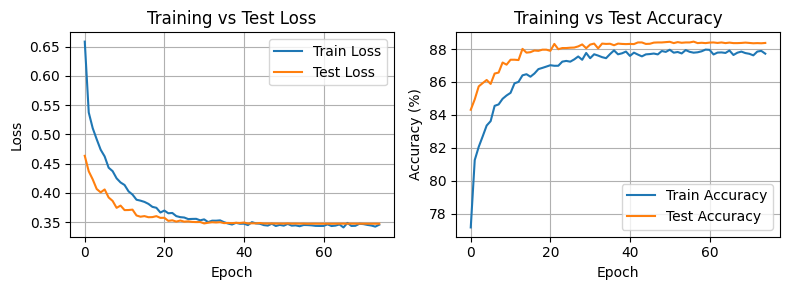

In [7]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
